# Introduction

This document is an analysis of the search algorithms and heuristics that were used to solve the three Air cargo problems described in the project.

The experimental settings were as follows:
- __search limit__: up to the memory limit (16 GiB), no timeout
- __elements tested__: all problems (3) and searches (10) were tested
- __benchmark sript__: a modified run_search.py that output json files
- __hardware__: Processor 8 x Intel Core i7-4710Hq CPU 2.50 GHz, 16 GiB of RAM

In the first part of this analysis, we will prepare the data prior to its exploration.

Then, we will review the main four characteristics associated to AI search algorithms:
  * optimality
  * completeness
  * time complexity
  * space complexity

Finally, we will provide an answer to suggest which algorithm should be used in the general case.

# Preparation

In [20]:
from itertools import product
from glob import iglob
import pandas as pd
import numpy as np
import json
import os
import re

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)

In [21]:
# files and formats
DIR = '../data/run/'
FILES = iglob(os.path.join(DIR, '*.json'))
RES_PAT = re.compile('air_cargo_problem_(\d+)-(\w+)-(\w+)')
COLUMNS = ['problem', 'search', 'algorithm', 'heuristic', 'uninformed', 'runtime', 
           'plan_length', 'expansions', 'goal_tests', 'new_nodes', 'plan']

# problems and searches
PROBLEMS = ['1', '2', '3']

SEARCHES = [
    ["breadth_first_search", "uninformed"],
    ['breadth_first_tree_search', "uninformed"],
    ['depth_first_graph_search', "uninformed"],
    ['depth_limited_search', "uninformed"],
    ['uniform_cost_search', "uninformed"],
    ['recursive_best_first_search', 'h_1'],
    ['greedy_best_first_graph_search', 'h_1'],
    ['astar_search', 'h_1'],
    ['astar_search', 'h_ignore_preconditions'],
    ['astar_search', 'h_pg_levelsum'],
]

def sname(algo, heur):
    """Format an algorithm and heuristic to a search name."""
    return "{} - {}".format(algo, heur).replace('_', ' ')


RESULTS = list()

# import results
for f in FILES:
    file, ext = os.path.splitext(f) 
    filename = os.path.basename(file)
    match = RES_PAT.match(filename)
    
    if match is None:
        raise ValueError("Match failed for: {}".format(filename))
        
    prob, algo, heur = match.groups()
    uninformed = heur == 'uninformed'
    
    with open(f, 'r') as r:
        res = json.load(r)
    
    res['problem'] = prob
    res['algorithm'] = algo
    res['heuristic'] = heur
    res['uninformed'] = uninformed
    res['search'] = sname(algo, heur)
    
    RESULTS.append(res)

# create a dataframe from results
df = pd.DataFrame(RESULTS, columns=COLUMNS).sort_values(['problem', 'heuristic'])

# Visualization

## Overview

In [22]:
df.drop(['search', 'plan'], axis=1)

,problem,algorithm,heuristic,uninformed,runtime,plan_length,expansions,goal_tests,new_nodes
10,1,greedy_best_first_graph_search,h_1,False,0.010160,6,7,9,28
12,1,astar_search,h_1,False,0.118958,6,55,57,224
22,1,recursive_best_first_search,h_1,False,4.504784,6,4229,4230,17023
17,1,astar_search,h_ignore_preconditions,False,0.076575,6,41,43,170
7,1,astar_search,h_pg_levelsum,False,10.033305,6,18,20,77
1,1,depth_first_graph_search,uninformed,True,0.021924,20,21,22,84
2,1,breadth_first_tree_search,uninformed,True,1.592876,6,1458,1459,5960
9,1,depth_limited_search,uninformed,True,0.146723,50,101,271,414
13,1,uniform_cost_search,uninformed,True,0.049170,6,55,57,224
15,1,breadth_first_search,uninformed,True,0.024268,6,43,56,180


## Completeness

In [23]:
def is_complete(df, p, a, h):
    return ((df['problem'] == p) & (df['algorithm'] == a) & (df['heuristic'] == h)).any()


COMPLETES = list()

for p, s in product(PROBLEMS, SEARCHES):
    a, h = s
    
    doc = {
        'problem': p,
        'search': sname(a, h),
        'complete': 1 if is_complete(df, p, a, h) else 0
    }
    
    COMPLETES.append(doc)
    
complete = pd.DataFrame(COMPLETES, columns=['problem', 'search', 'complete']) \
             .sort_values('problem')

In [24]:
complete

,problem,search,complete
0,1,breadth first search - uninformed,1
1,1,breadth first tree search - uninformed,1
2,1,depth first graph search - uninformed,1
3,1,depth limited search - uninformed,1
4,1,uniform cost search - uninformed,1
5,1,recursive best first search - h 1,1
6,1,greedy best first graph search - h 1,1
7,1,astar search - h 1,1
8,1,astar search - h ignore preconditions,1
9,1,astar search - h pg levelsum,1


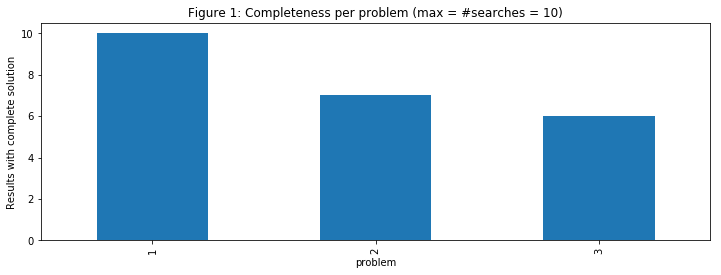

In [25]:
ax = complete.groupby('problem').sum().sort_values('complete', ascending=False)['complete'].plot(kind='bar')
ax.set_title('Figure 1: Completeness per problem (max = #searches = {})'.format(len(SEARCHES)))
ax.set_ylabel('Results with complete solution')
None

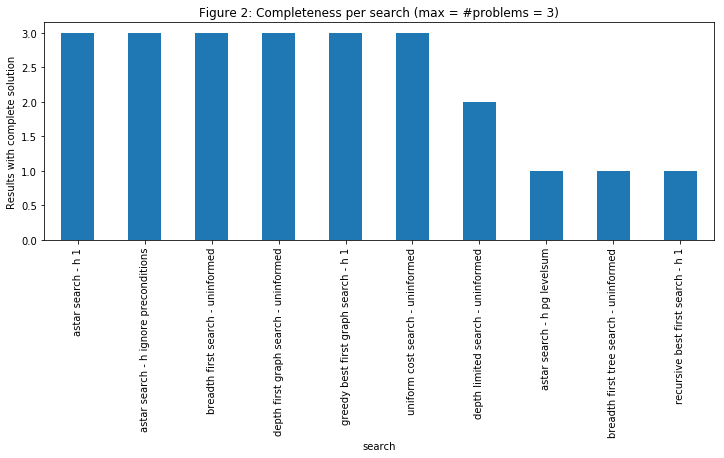

In [26]:
ax = complete.groupby('search').sum().sort_values('complete', ascending=False)['complete'].plot(kind='bar')
ax.set_title('Figure 2: Completeness per search (max = #problems = {})'.format(len(PROBLEMS)))
ax.set_ylabel('Results with complete solution')
None

Out of 30 cases, we found that 23 cases have a complete solution in our experimental settings.

We can see from Figure 1 that it is easier to find a complete solution for smaller problems (e.g. Problem 1).

We can see from Figure 2 that some searches that were supposed to had complete solution, such as breadth first tree and A\* search, were not complete in our settings. The reason might be the lack of memory on the machine.

On the contrary, some searches which do not guarantee completeness, such as greedy best first graph search and depth first graph search, had a complete solution. As mentioned, these algorithms can find a solution in some cases, and the result do not contradict that we learned in the session. 

## Optimality

In [27]:
BEST = {'1': 6, '2': 9, '3': 12}

def is_optimal(row):
    return row['plan_length'] == BEST[row['problem']]


optimal = df[['problem', 'search', 'plan_length', 'plan']].copy()
optimal['optimal'] = optimal.apply(lambda r: 1 if is_optimal(r) else 0, axis=1)

In [28]:
optimal.drop('plan', axis=1)

,problem,search,plan_length,optimal
10,1,greedy best first graph search - h 1,6,1
12,1,astar search - h 1,6,1
22,1,recursive best first search - h 1,6,1
17,1,astar search - h ignore preconditions,6,1
7,1,astar search - h pg levelsum,6,1
1,1,depth first graph search - uninformed,20,0
2,1,breadth first tree search - uninformed,6,1
9,1,depth limited search - uninformed,50,0
13,1,uniform cost search - uninformed,6,1
15,1,breadth first search - uninformed,6,1


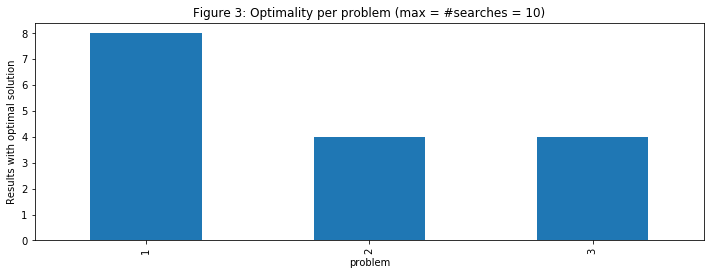

In [29]:
ax = optimal.groupby('problem').sum().sort_values('optimal', ascending=False)['optimal'].plot(kind='bar')
ax.set_title('Figure 3: Optimality per problem (max = #searches = {})'.format(len(SEARCHES)))
ax.set_ylabel('Results with optimal solution')
None

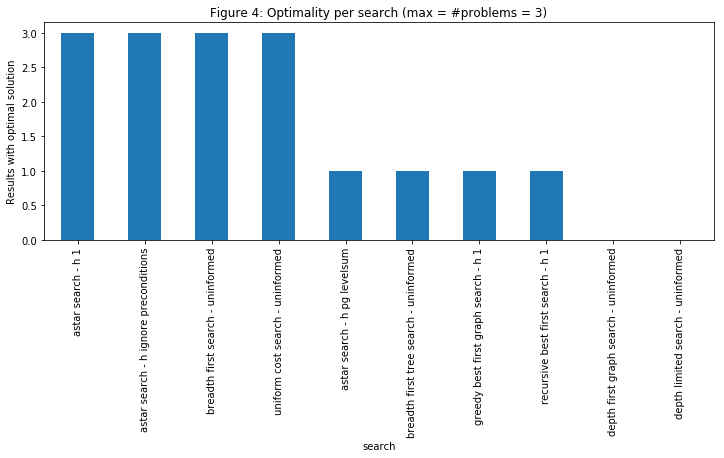

In [30]:
ax = optimal.groupby('search').sum().sort_values('optimal', ascending=False)['optimal'].plot(kind='bar')
ax.set_title('Figure 4: Optimality per search (max = #problems = {})'.format(len(PROBLEMS)))
ax.set_ylabel('Results with optimal solution')
None

Out of 30 cases, we found that 16 cases have an optimal solution.

In Figure 3, we see that an optimal solution was easier to found for smaller problems. At this scale, finding an optimal solution for small problem could be influenced by a factor of chance.

In Figure 4, we see that 4 search algorithms consistently found an optimal solution. This confirm what we learned in the textbook about the optimality of certain algorithms, such as A\*, breadth-first search and uniform cost search algorithm. On the other hand, other search algorithms such as greedy search and depth first search do not have this guarantee, which is shown in the results as well.

We also found some search algorithm supposed to be optimal but without optimal solutions in our experiment, such as breadth first tree search. However, we we observed prior to this analysis that these searches were incomplete.

## Time complexity

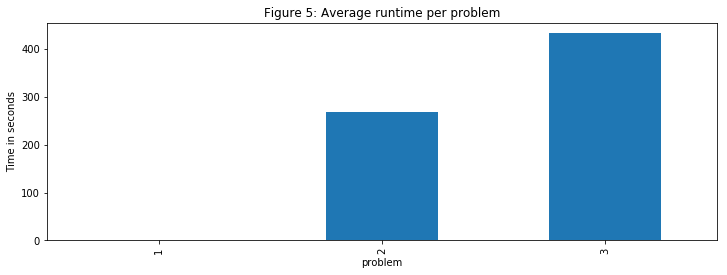

In [31]:
ax = df.groupby('problem').mean()['runtime'].sort_values().plot(kind='bar')
ax.set_title('Figure 5: Average runtime per problem')
ax.set_ylabel('Time in seconds')
None

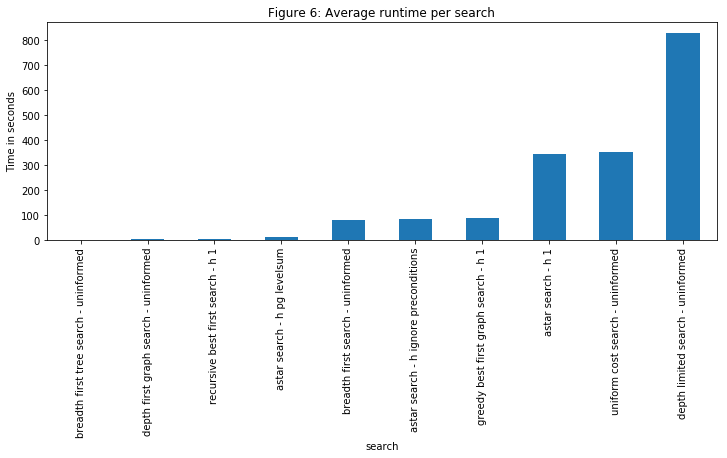

In [32]:
ax = df.groupby('search').mean()['runtime'].sort_values().plot(kind='bar')
ax.set_title('Figure 6: Average runtime per search')
ax.set_ylabel('Time in seconds')
None

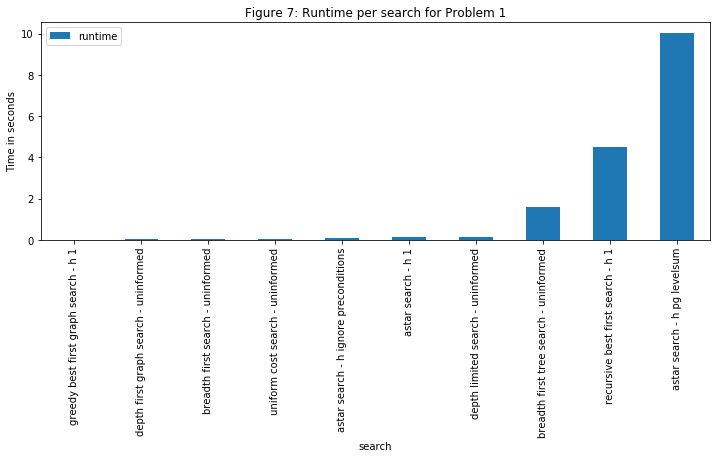

In [33]:
ax = df[df['problem'] == '1'].sort_values('runtime').plot(x='search', y='runtime', kind='bar')
ax.set_title('Figure 7: Runtime per search for Problem 1')
ax.set_ylabel('Time in seconds')
None

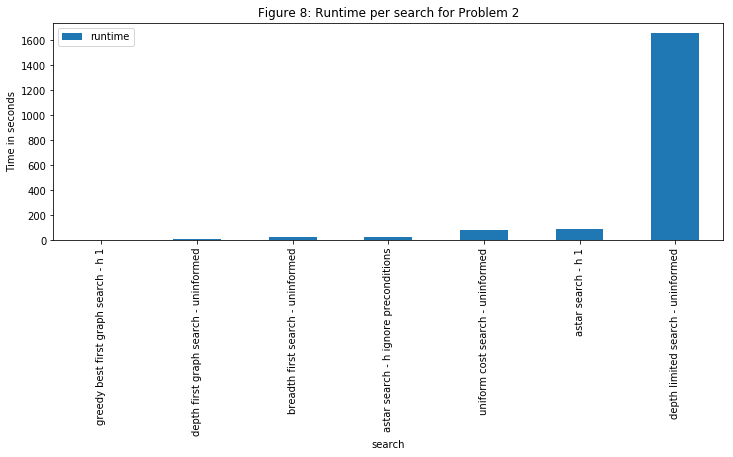

In [34]:
ax = df[df['problem'] == '2'].sort_values('runtime').plot(x='search', y='runtime', kind='bar')
ax.set_title('Figure 8: Runtime per search for Problem 2')
ax.set_ylabel('Time in seconds')
None

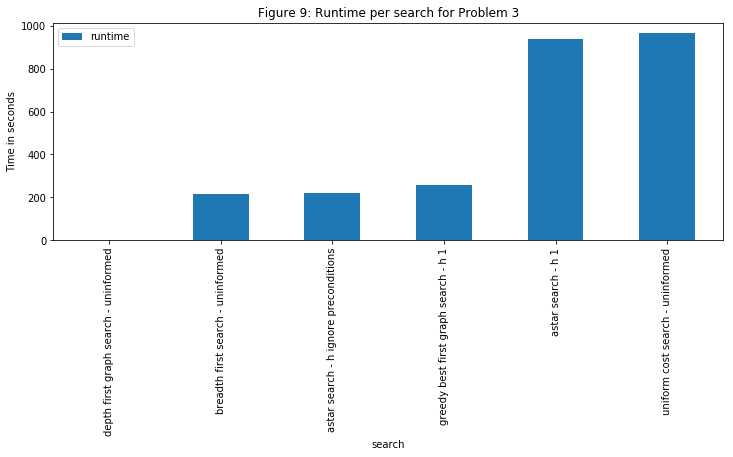

In [35]:
ax = df[df['problem'] == '3'].sort_values('runtime').plot(x='search', y='runtime', kind='bar')
ax.set_title('Figure 9: Runtime per search for Problem 3')
ax.set_ylabel('Time in seconds')
None

In figure 5, we can see that the time complexity varies greatly depending on the complexity of the problem, from less than 1 second for Problem 1 to more than 400 seconds on average for problem 3. This is due to the algorithmic complexity associated to search algorithms, which are exponential in most cases.

In figure 6, we see that the average runtime per search depends on the algorithm. Greedy and depth-first searches tend to have smaller runtime than breadth-first search and A\* algorithms. On the other hand, we solution they found were not optimal.

In the context of the Air Cargo Problem, finding an optimal solution is much important than the runtime of the search algorithm. A company would be more inclined to spend more computer resources and avoid the cost of flying more planes than necessary. The cost of the latter is much greater than the former. The only constraint in this case is to find search algorithms with tractable executions.

## Space Complexity

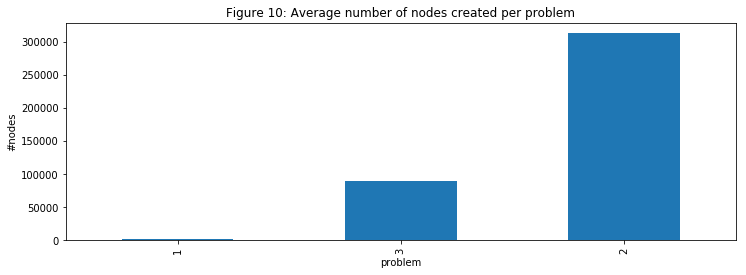

In [36]:
ax = df.groupby('problem').mean()['new_nodes'].sort_values().plot(kind='bar')
ax.set_title('Figure 10: Average number of nodes created per problem')
ax.set_ylabel('#nodes')
None

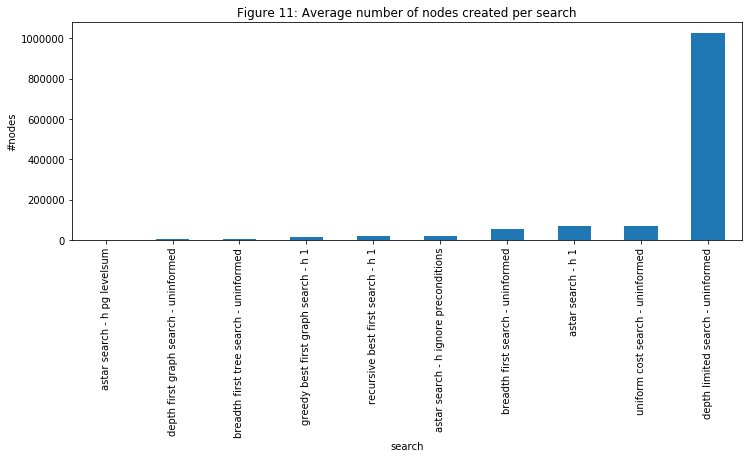

In [37]:
ax = df.groupby('search').mean()['new_nodes'].sort_values().plot(x='problem', y='new_nodes', kind='bar')
ax.set_title('Figure 11: Average number of nodes created per search')
ax.set_ylabel('#nodes')
None

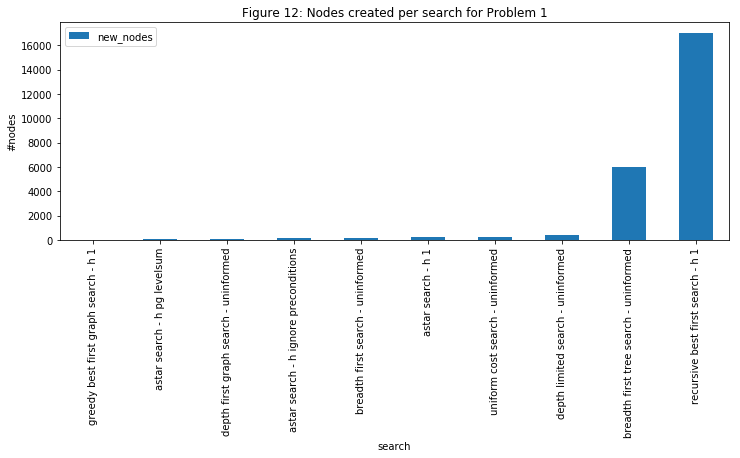

In [38]:
ax = df[df['problem'] == '1'].sort_values('new_nodes').plot(x='search', y='new_nodes', kind='bar')
ax.set_title('Figure 12: Nodes created per search for Problem 1')
ax.set_ylabel('#nodes')
None

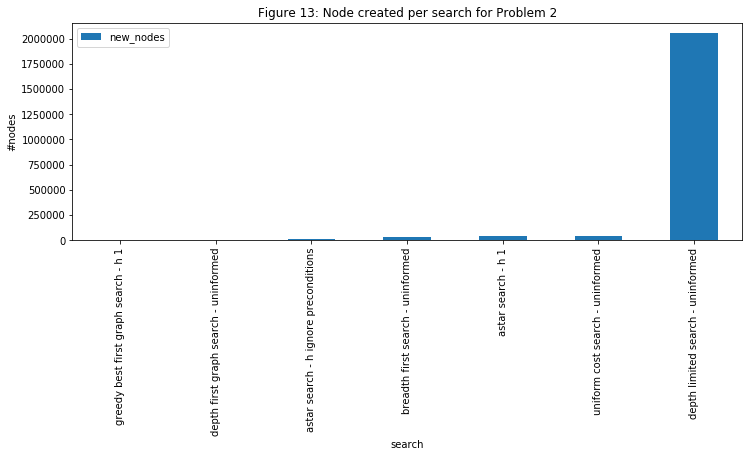

In [39]:
ax = df[df['problem'] == '2'].sort_values('new_nodes').plot(x='search', y='new_nodes', kind='bar')
ax.set_title('Figure 13: Node created per search for Problem 2')
ax.set_ylabel('#nodes')
None

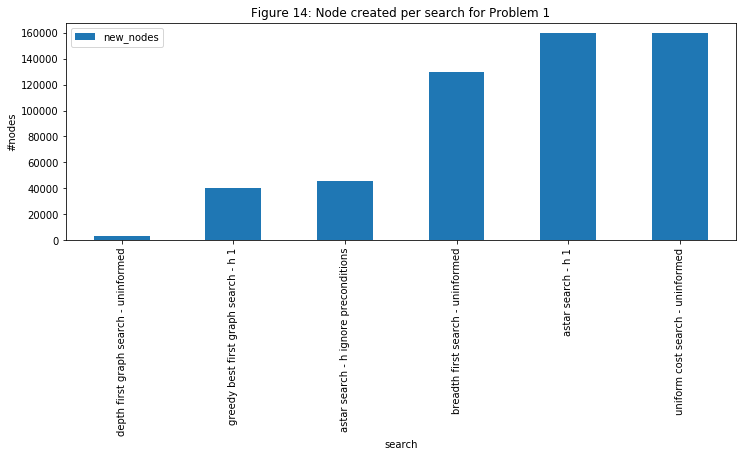

In [40]:
ax = df[df['problem'] == '3'].sort_values('new_nodes').plot(x='search', y='new_nodes', kind='bar')
ax.set_title('Figure 14: Node created per search for Problem 1')
ax.set_ylabel('#nodes')
None

We may be surprised to find in Figure 10 than more nodes were created for Problem 2 than Problem 3. This is because most searches could not be completed for Problem 3, while they could for Problem 2, at the cost of more expansions.

In figure 11, it is striking to see the high number of node created for depth-limited search compare to the other algorithms. In this particular case, the depth-limited search must do more work when the depth limit increases, causing more expansions than the other algorithms.

Overall, the number of node created is not a problem with the resources we have on our machine today, as long as the search can be completed at some point. 

## Summary

__The following searches had incomplete in our settings__:
* astar search - h pg levelsum
* depth limited search - uninformed
* recursive best first search - h 1
* breadth first tree search - uninformed

__The following searches had non optimal results__:
* depth limited search - uninformed
* greedy best first graph search - h 1
* depth first graph search - uninformed	

__The following searches had a runtime greater than 400 seconds__:
* astar search - h 1
* uniform cost search - uninformed
* depth limited search - uninformed

__The following searches created more than 100 000 new nodes__:
* astar search - h 1
* uniform cost search - uninformed	
* depth limited search - uninformed
* breadth first search - uninformed

__The following searches are not included in the previous listings__:
* astar_search - h_ignore_preconditions

# Conclusion

Through this report, we analyzed the main characteristics of search algorithms and confirmed the theory learned in this session on planning and search. We noticed that even for small problems, some algorithms were not tractable or did not provided sufficient solutions.

In particular, the capacity to find optimal and complete solution is critical in the case of flying planes. The high cost of this activity could greatly benefit from the solutions that some of these algorithms can provide. The main constraint is for optimal algorithms to be tractable, both in term of time and space complexity.

The only algorithm which had this property is the A\* search with the "ignore preconditions" heuristic. This search was always optimal and complete in our settings. Moreover, it had acceptable time and space complexity. The heuristic exposed one of the critical insight that I learned through this session: an heuristic could be created automatically by relaxing some of the problem constraints (such as removing preconditions). I think this is a powerful idea that could improve the automation of AI techniques for new problem domain.

You can find in the appendix below the optimal solutions that were found for each three problems.

# Appendix

## Optimal plans

In [41]:
for problem, group in optimal[optimal['optimal']].groupby('problem'):
    
    plans = {'\n'.join(plan) for plan in group['plan']}
    print("### Problem: {} (#plans = {}) ###".format(problem, len(plans)))
    print()
    
    for i, plan in enumerate(plans, 1):
        print("- Plan: {}".format(i))
        print(plan)
        print()

ValueError: Grouper for 'problem' not 1-dimensional